In [1]:
import torch
from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration
from trl import AutoModelForCausalLMWithValueHead
from qwen_vl_utils import process_vision_info
from transformers.utils import cached_file
from safetensors import safe_open

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
!ls /mnt/user-ssd/lilei35/trl/vlm_reward_model_balance_100_en_zh_total30k
#/mnt/user-ssd/lilei35/trl/vlm_reward_model_debug

chat_template.json  checkpoint-2100  checkpoint-700
checkpoint-100	    checkpoint-2200  checkpoint-800
checkpoint-1000     checkpoint-2300  checkpoint-900
checkpoint-1100     checkpoint-2400  config.json
checkpoint-1200     checkpoint-2500  full_args.json
checkpoint-1300     checkpoint-2600  generation_config.json
checkpoint-1400     checkpoint-2700  merges.txt
checkpoint-1500     checkpoint-2800  model.safetensors
checkpoint-1600     checkpoint-2900  model.safetensors.index.json
checkpoint-1700     checkpoint-300   preprocessor_config.json
checkpoint-1800     checkpoint-3000  tokenizer.json
checkpoint-1900     checkpoint-400   tokenizer_config.json
checkpoint-200	    checkpoint-500   training_args.bin
checkpoint-2000     checkpoint-600   vocab.json


In [3]:
!nvidia-smi

Mon May 26 02:26:35 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H800                    On  | 00000000:61:00.0 Off |                    0 |
| N/A   33C    P0             125W / 700W |   7275MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
rm_path = "/mnt/user-ssd/lilei35/trl/vlm_reward_model_balance_100_en_zh_total30k"
processor = AutoProcessor.from_pretrained(rm_path)
device = "cuda:5"
# The default range for the number of visual tokens per image in the model is 4-16384.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Skywork/Skywork-VL-Reward-7B", min_pixels=min_pixels, max_pixels=max_pixels)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "/mnt/user-ssd/lilei35/oss_models/Qwen2.5-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
).to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
rm_model = AutoModelForCausalLMWithValueHead.from_pretrained(model)

In [11]:
with safe_open(file, framework="pt", device="cpu") as f:
    original_state_dict =  {  key: f.get_tensor(key) for key in f.keys()}


In [12]:
print(original_state_dict.keys())


dict_keys(['lm_head.weight', 'model.embed_tokens.weight', 'model.layers.0.input_layernorm.weight', 'model.layers.0.mlp.down_proj.weight', 'model.layers.0.mlp.gate_proj.weight', 'model.layers.0.mlp.up_proj.weight', 'model.layers.0.post_attention_layernorm.weight', 'model.layers.0.self_attn.k_proj.bias', 'model.layers.0.self_attn.k_proj.weight', 'model.layers.0.self_attn.o_proj.weight', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.0.self_attn.q_proj.weight', 'model.layers.0.self_attn.v_proj.bias', 'model.layers.0.self_attn.v_proj.weight', 'model.layers.1.input_layernorm.weight', 'model.layers.1.mlp.down_proj.weight', 'model.layers.1.mlp.gate_proj.weight', 'model.layers.1.mlp.up_proj.weight', 'model.layers.1.post_attention_layernorm.weight', 'model.layers.1.self_attn.k_proj.bias', 'model.layers.1.self_attn.k_proj.weight', 'model.layers.1.self_attn.o_proj.weight', 'model.layers.1.self_attn.q_proj.bias', 'model.layers.1.self_attn.q_proj.weight', 'model.layers.1.self_attn.v_proj.bia

In [16]:
file = f"{rm_path}/model.safetensors"

# pretrained_model.visual.merger.mlp.2.bias
# pretrained_model.model.embed_tokens.weight
with safe_open(file, framework="pt", device="cpu") as f:
    rm_state_dict = {  key: f.get_tensor(key) for key in f.keys()}
    renamed_rm_state_dict = {}
    for key, value in rm_state_dict.items():
        if 'visual' in key or 'model.' in key or 'lm_head' in key: # vit or llm
            renamed_rm_state_dict['pretrained_model.' + key] = value
        elif 'v_head' in key:
            renamed_rm_state_dict[key] = value
    rm_state_dict = renamed_rm_state_dict
    # print(rm_state_dict.keys())

In [17]:
for n, p in rm_model.named_parameters():
    if n not in rm_state_dict:
        print(n)

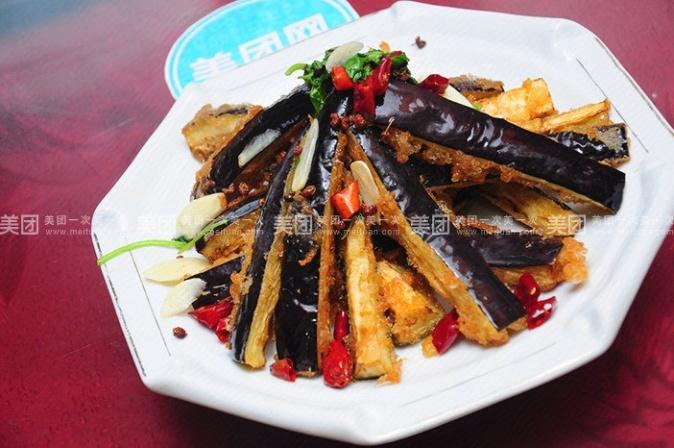

In [19]:
from PIL import Image
demo_img = "qiezi.jpg"
Image.open(demo_img)

In [20]:
rm_model.load_state_dict(rm_state_dict, strict=True)

<All keys matched successfully>

In [21]:
rm_model.requires_grad_(False)
rm_model.eval()

AutoModelForCausalLMWithValueHead(
  (pretrained_model): Qwen2_5_VLForConditionalGeneration(
    (visual): Qwen2_5_VisionTransformerPretrainedModel(
      (patch_embed): Qwen2_5_VisionPatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2_5_VLVisionBlock(
          (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
          (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
          (attn): Qwen2_5_VLVisionFlashAttention2(
            (qkv): Linear(in_features=1280, out_features=3840, bias=True)
            (proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (mlp): Qwen2_5_VLMLP(
            (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (down_proj): Linear(in_features=3420, out_features=1280, bias

In [23]:
demo_img = "/mnt/user-ssd/lilei35/trl/qiezi.jpg"
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": demo_img,
            },
            {
                "type": "text",
                "text": "这是什么菜?",
            },
        ],
    },
    {
        "role": "assistant",
        "content": "美味茄子",
    },
]
device = "cuda:5"

text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=False
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to(device)
new_inputs = {}
for k, v in inputs.items():
    new_inputs[k] = v.to(device)
    print(new_inputs[k].device)
# rm_model.pretrained_model = rm_model.pretrained_model.to(device)
values = rm_model(**new_inputs, return_dict=True, use_cache=False)[-1]
print(values.device)
scores = values.gather(
    dim=-1, index=(new_inputs["attention_mask"].to('cpu').sum(dim=-1, keepdim=True) - 1)
)
score = scores[0].item()
print("Reward Score is: ", score)

cuda:5
cuda:5
cuda:5
cuda:5
cpu
Reward Score is:  -2.578627347946167


In [28]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": "这是什么菜?",
            },
            {
                "type": "image",
                "image": demo_img,
            },
        ],
    },
    {
        "role": "assistant",
        "content": "这是一道美味的脆皮茄子",
    },]
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=False
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to(device)
new_inputs = {}
for k, v in inputs.items():
    new_inputs[k] = v.to(device)
    print(new_inputs[k].device)
# rm_model.pretrained_model = rm_model.pretrained_model.to(device)
values = rm_model(**new_inputs, return_dict=True, use_cache=False)[-1]
print(values.device)
scores = values.gather(
    dim=-1, index=(new_inputs["attention_mask"].to('cpu').sum(dim=-1, keepdim=True) - 1)
)
score = scores[0].item()

cuda:5
cuda:5
cuda:5
cuda:5


NameError: name 'apply_rotary_emb' is not defined

In [29]:
image_inputs

[<PIL.Image.Image image mode=RGB size=672x448>]

In [27]:
type(video_inputs)

NoneType

In [28]:
print(score)

7.2400617599487305
